# Chapter 8.4 - Generating images with VAEs

In [1]:
import keras
from keras.layers import Input, Conv2D, Dense, Flatten
from keras import backend as K
from keras.models import Model
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_shape = (28, 28, 1)
batch_size = 16
# Dimensionality of the latent space: a plane
latent_dim = 2  

In [3]:
input_img = Input(shape = img_shape)

x = Conv2D(filters = 32, 
           kernel_size = (3, 3),
           padding = 'same', 
           activation = 'relu')(input_img)
x = Conv2D(filters = 64, 
           kernel_size = (3, 3),
           padding ='same', 
           activation = 'relu',
           strides = (2, 2))(x)
x = Conv2D(filters = 64, 
           kernel_size = (3, 3),
           padding = 'same', 
           activation = 'relu')(x)
x = Conv2D(filters = 64, 
           kernel_size = (3, 3),
           padding = 'same', 
           activation = 'relu')(x)
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(units = 32, 
          activation = 'relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [4]:
from keras.layers import Lambda, Reshape, Conv2DTranspose

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], 
                                       latent_dim),
                              mean = 0., 
                              stddev = 1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [6]:
# This is the input where we will feed `z`.
decoder_input = Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = Dense(units = np.prod(shape_before_flattening[1:]),
          activation = 'relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = Conv2DTranspose(filters = 32, 
                    kernel_size = (3, 3),
                    padding='same', 
                    activation='relu',
                    strides = (2, 2))(x)
x = Conv2D(filters = 1, 
           kernel_size = (3, 3),
           padding = 'same', 
           activation = 'sigmoid')(x)

# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

## Custom variational layer

In [7]:
from keras.layers import Layer

In [8]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), 
                                 axis = -1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [9]:
vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  


## Loading and preprocessing of the MNIST dataset

In [10]:
from keras.datasets import mnist

In [11]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [12]:
vae.fit(x = x_train, 
        y = None,
        shuffle = True,
        epochs = 10,
        batch_size = batch_size,
        validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 53s 875us/step - loss: 0.2135 - val_loss: 0.1966
Epoch 2/10
60000/60000 [==============================] - 50s 826us/step - loss: 0.1930 - val_loss: 0.1899
Epoch 3/10
60000/60000 [==============================] - 51s 855us/step - loss: 0.1886 - val_loss: 0.1863
Epoch 4/10
60000/60000 [==============================] - 51s 844us/step - loss: 0.1861 - val_loss: 0.1848
Epoch 5/10
60000/60000 [==============================] - 52s 863us/step - loss: 0.1844 - val_loss: 0.1828
Epoch 6/10
60000/60000 [==============================] - 45s 749us/step - loss: 0.1832 - val_loss: 0.1836
Epoch 7/10
60000/60000 [==============================] - 45s 746us/step - loss: 0.1821 - val_loss: 0.1815
Epoch 8/10
60000/60000 [==============================] - 45s 748us/step - loss: 0.1813 - val_loss: 0.1807
Epoch 9/10
60000/60000 [==============================] - 45s 750us/step - loss: 0.1806 - val_

## Visualizing the results

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [14]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits

digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [15]:
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit



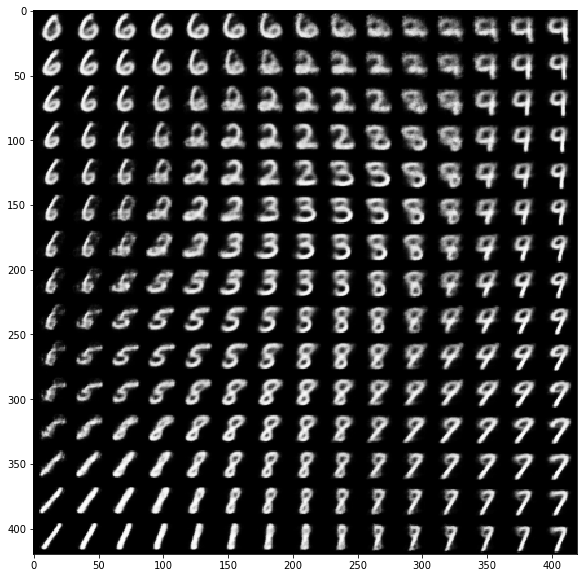

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()